In [8]:
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
from IPython.display import display
import warnings
warnings.simplefilter('always')
import importlib
from matplotlib import cm

from scripts.a_data_loading_cleaning import run_load_clean_diagnose_data

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Data Loading & Cleaning

In [9]:
csv_path = f"results/scenarios_results.csv"
df = run_load_clean_diagnose_data(csv_path)

✅ Total generated tokens value is constant: 16384
Original distribution:
total_generated_tokens
16384    16
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
Round 1: Verfifying FLOPs on raw df
NB: FLOPs values are NOT constant: [52638582308864 20248623316992]
Original distribution:
flops
20248623316992     6
52638582308864    10
Name: count, dtype: int64

Dominant FLOPs value: 52638582308864
- Affected rows count: 6
- Affected row indices: [1, 2, 3, 4, 5, 6]
- Affected configs: ['A1_Single_GPU', 'R5_Tail_SingleGPU_Greedy', 'R6_Tail_DualGPU_TopP', 'R1_Ultralow_SingleGPU_Greedy', 'R2_Ultralow_DualGPU_TopP', 'A4_Parallel_Exploit']
----------------------------------------------------------------------------------------------------
FLOP Differentiators:
Round 2: Verfifying FLOPs on corrected df
NB: FLOPs values are NOT constant: [1.69499710e+13 5.26385823e+13]
Original distribution:
flops
1.694997e+13    8
5.26385

/Users/henrybaker/repositories/thesis_analysis/scripts/a_data_loading_cleaning.py:611: UserWarning: NB: FLOPs values are NOT constant: [52638582308864 20248623316992]
  if not verify_flops(df):
/Users/henrybaker/repositories/thesis_analysis/scripts/a_data_loading_cleaning.py:621: UserWarning: NB: FLOPs values are NOT constant: [1.69499710e+13 5.26385823e+13]
  verify_flops(df)


# Basic understanding on contents

In [10]:
print(f"number of observation: {len(df)}")
print(f"number of scenarios: {len(df['config_name'].unique())}")
print(f"distribution of scenarios:{df['config_name'].value_counts()}")

number of observation: 16
number of scenarios: 8
distribution of scenarios:config_name
A3_Quantisation_Focus           2
A1_Single_GPU                   2
R5_Tail_SingleGPU_Greedy        2
R6_Tail_DualGPU_TopP            2
R1_Ultralow_SingleGPU_Greedy    2
R2_Ultralow_DualGPU_TopP        2
A4_Parallel_Exploit             2
A2_2_GPU                        2
Name: count, dtype: int64


In [11]:
cols_to_describe = [
    'total_energy_kwh',
    'total_inference_time_sec',
    'average_latency_ms_per_batch',
    'throughput_queries_per_sec',
    'throughput_tokens_per_sec',
    'cpu_energy_total',
    'gpu_energy_total',
    'flops_per_token',
    'energy_per_token_kwh',
    'divergence_energy_flops'
]

df[cols_to_describe].describe()

,total_energy_kwh,total_inference_time_sec,average_latency_ms_per_batch,throughput_queries_per_sec,throughput_tokens_per_sec,cpu_energy_total,gpu_energy_total,flops_per_token,energy_per_token_kwh,divergence_energy_flops
count,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,1.600000e+01,1.600000e+01,1.600000e+01
mean,0.012984,115.163893,4252.016592,9.940071,1272.329107,0.005331,0.007620,2.123674e+09,7.925069e-07,4.187923e-16
std,0.020289,164.480715,1707.080154,11.430864,1463.150574,0.008102,0.012452,1.124849e+09,1.238351e-06,6.124884e-16
min,0.000530,3.187716,2185.761334,0.269539,34.501025,0.000154,0.000345,1.034544e+09,3.234939e-08,2.046611e-17
25%,0.001665,8.089505,3419.967402,1.282290,164.133057,0.000409,0.001080,1.034544e+09,1.016496e-07,6.625976e-17
50%,0.004347,34.599849,3714.911230,5.976985,765.054060,0.001392,0.003226,2.123674e+09,2.653297e-07,1.730314e-16
75%,0.013675,131.592796,5090.391718,15.846543,2028.357548,0.005917,0.008179,3.212804e+09,8.346319e-07,4.899503e-16
max,0.078608,474.884436,8265.675273,40.154142,5139.730233,0.028514,0.049893,3.212804e+09,4.797841e-06,2.202050e-15


In [12]:
# set colours
all_models = sorted(set(df['model']))
n = len(all_models)

# base colormaps
cmap_energy     = cm.get_cmap('Blues')
cmap_throughput = cm.get_cmap('Reds')

# sample only from the mid→dark part of each map
energy_colors     = [cmap_energy(0.5 + 0.5 * i/(n-1)) for i in range(n)]
throughput_colors = [cmap_throughput(0.5 + 0.2 * i/(n-1)) for i in range(n)]

MODEL_COLOURS = {
    m: {
        'energy':     energy_colors[i],
        'throughput': throughput_colors[i]
    }
    for i, m in enumerate(all_models)
}

/var/folders/9b/zwzkyxhs7h7759872hzp3mz80000gn/T/ipykernel_75676/3422303312.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_energy     = cm.get_cmap('Blues')
/var/folders/9b/zwzkyxhs7h7759872hzp3mz80000gn/T/ipykernel_75676/3422303312.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_throughput = cm.get_cmap('Reds')


In [13]:
import scripts.b_exploratory_data_analysis as eda
importlib.reload(eda)

#eda.plot_all_diagnostics(df, MODEL_COLOURS=MODEL_COLOURS)


<module 'scripts.b_exploratory_data_analysis' from '/Users/henrybaker/repositories/thesis_analysis/scripts/b_exploratory_data_analysis.py'>

# Basic stats

In [14]:
from scripts.f_scenario_analysis import get_descriptive_stats
get_descriptive_stats(df)


Models: ['Llama-3.2-1B', 'Llama-3.2-3B']

--- Llama-3.2-1B (raw data) ---
Max mean energy: 0.0000 kWh @ R2_Ultralow_DualGPU_TopP
Min mean energy: 0.0000 kWh @ A1_Single_GPU
- Energy reduction (worst→best): 98.58%
- Range vs. mean of means: 427.54%
- Range vs. min baseline: 6942.23%

Normalized to min baseline:
                 config_name  norm_to_min  diff_to_min_pct
               A1_Single_GPU     1.000000         0.000000
                    A2_2_GPU     3.426802         2.426802
       A3_Quantisation_Focus     1.098396         0.098396
         A4_Parallel_Exploit     6.867034         5.867034
R1_Ultralow_SingleGPU_Greedy    26.029759        25.029759
    R2_Ultralow_DualGPU_TopP    70.422277        69.422277
    R5_Tail_SingleGPU_Greedy     5.550543         4.550543
        R6_Tail_DualGPU_TopP    15.505757        14.505757

Variability & distribution:
 Count: 8
 Std dev: 0.0000 kWh (144.62% of mean)
 Quartiles (25% / 50% / 75%): 0.0000, 0.0000, 0.0000
 IQR: 0.0000
 Skewness: 0

<Axes: title={'center': 'Distribution of Normalised Energy per Token'}, xlabel='Energy per Token (normalised by mean) \n"How many times bigger (or smaller) is this value than the average?"', ylabel='Frequency'>

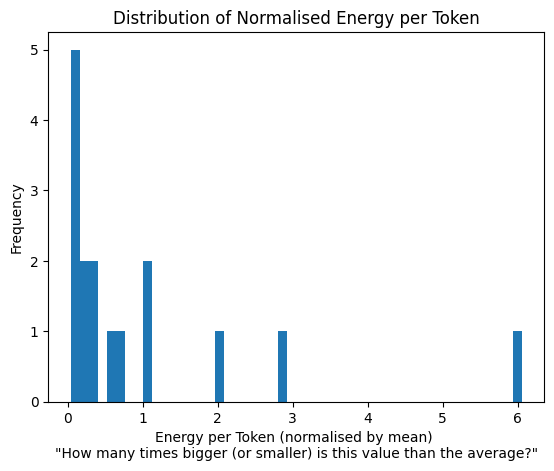

In [15]:
(df['energy_per_token_kwh'] / df['energy_per_token_kwh'].mean()).plot(
    kind='hist',
    bins=50,
    title='Distribution of Normalised Energy per Token',
    xlabel='Energy per Token (normalised by mean) \n"How many times bigger (or smaller) is this value than the average?"',
    ylabel='Frequency'
)

# Absolute Numbers

In [16]:
from scripts.f_scenario_analysis import compare_energy_to_appliances
compare_energy_to_appliances(df)

== ASSUMING AVERAGE LENGTH: 300 TOKENS ==
Models: ['Llama-3.2-1B', 'Llama-3.2-3B']

=== Model: Llama-3.2-1B ===
-- Scenario: Full config means (8 configs) --
Overall ratio (max/min): 70.42
# responses to match appliance (worst/best/diff/mean):
    iPhone_charge: worst 21.95, best 1545.62, diff 22.26, mean 95.19
    MacBook_charge: worst 117.06, best 8243.33, diff 118.74, mean 507.67
    wifi_router_24h: worst 351.17, best 24729.99, diff 356.23, mean 1523.01
    streaming_1hr: worst 877.92, best 61824.97, diff 890.56, mean 3807.53
    google_search: worst 0.44, best 30.91, diff 0.45, mean 1.90
    kettle: worst 109.74, best 7728.12, diff 111.32, mean 475.94
    shower: worst 2311.85, best 162805.75, diff 2345.15, mean 10026.48

-- Scenario: Without outlier configs (8 configs) --
Overall ratio (max/min): 70.42
# responses to match appliance (worst/best/diff/mean):
    iPhone_charge: worst 21.95, best 1545.62, diff 22.26, mean 95.19
    MacBook_charge: worst 117.06, best 8243.33, diff 118

# Artifical vs realistic

In [17]:
from scripts.f_scenario_analysis import artificial_v_realistic
artificial_v_realistic(df)


--- Llama-3.2-1B (raw data) ---
Realistic mean   : 0.00029 kWh/resp
Artificial mean  : 0.00003 kWh/resp
- Abs diff (A−R) : -0.00026 kWh
- Ratio (R/A)    : 9.48×
- % reduction    : -848.24%

--- Llama-3.2-1B (outliers removed (1.5×IQR)) ---
Realistic mean   : 0.00015 kWh/resp
Artificial mean  : 0.00003 kWh/resp
- Abs diff (A−R) : -0.00012 kWh
- Ratio (R/A)    : 5.07×
- % reduction    : -406.62%

--- Llama-3.2-3B (raw data) ---
Realistic mean   : 0.00057 kWh/resp
Artificial mean  : 0.00007 kWh/resp
- Abs diff (A−R) : -0.00049 kWh
- Ratio (R/A)    : 8.01×
- % reduction    : -700.89%

--- Llama-3.2-3B (outliers removed (1.5×IQR)) ---
Realistic mean   : 0.00027 kWh/resp
Artificial mean  : 0.00007 kWh/resp
- Abs diff (A−R) : -0.00020 kWh
- Ratio (R/A)    : 3.88×
- % reduction    : -288.07%


# Within-realistic

In [18]:
from scripts.f_scenario_analysis import within_realistic
within_realistic(df)


*** Llama-3.2-1B (Realistic — raw data) ***
Worst (max): R2_Ultralow_DualGPU_TopP @ 0.00068 kWh
Best  (min): R5_Tail_SingleGPU_Greedy @ 0.00005 kWh
- Abs diff  : 0.00063 kWh
- % reduction: 92.12%

*** Llama-3.2-1B (Realistic — outliers removed (1.5×IQR)) ***
Worst (max): R1_Ultralow_SingleGPU_Greedy @ 0.00025 kWh
Best  (min): R5_Tail_SingleGPU_Greedy @ 0.00005 kWh
- Abs diff  : 0.00020 kWh
- % reduction: 78.68%

*** Llama-3.2-3B (Realistic — raw data) ***
Worst (max): R2_Ultralow_DualGPU_TopP @ 0.00144 kWh
Best  (min): R5_Tail_SingleGPU_Greedy @ 0.00009 kWh
- Abs diff  : 0.00135 kWh
- % reduction: 94.09%

*** Llama-3.2-3B (Realistic — outliers removed (1.5×IQR)) ***
Worst (max): R1_Ultralow_SingleGPU_Greedy @ 0.00049 kWh
Best  (min): R5_Tail_SingleGPU_Greedy @ 0.00009 kWh
- Abs diff  : 0.00040 kWh
- % reduction: 82.53%
